## Download and explore COSMIC cancer genes

We want to download the set of cancer-associated genes from the [COSMIC Cancer Gene Census](https://cancer.sanger.ac.uk/cosmic/census), in order to use these genes in our experiments as a comparison/complement to the Vogelstein et al. gene set.

In [1]:
from pathlib import Path

import pandas as pd

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

### Load and process raw COSMIC data

This has to be downloaded directly from the CGC website linked above - you need an account there to download the .tsv file, so we can't do it programmatically.

In [2]:
cosmic_df = pd.read_csv(
    cfg.cosmic_genes_file, sep='\t', index_col=0
)

cosmic_df = cosmic_df[
    # use only tier 1 genes
    ((cosmic_df.Tier == 1) &
    # drop genes without a catalogued somatic mutation
     (cosmic_df.Somatic == 'yes') &
    # drop genes that are only observed in cancer as fusions
    # (we're not calling fusion genes in our mutation data)
     (cosmic_df['Role in Cancer'] != 'fusion'))
].copy()
     
print(cosmic_df.shape)
cosmic_df.head()

(445, 19)


,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
Gene Symbol,,,,,,,,,,,,,,,,,,,
ABI1,abl-interactor 1,10006,10:26746593-26860935,1,Yes,12.10,yes,NaN,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"10006,ABI-1,ABI1,E3B1,ENSG00000136754.17,Q8IZP..."
ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130713946-130885683,1,Yes,34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007.17,JTK7,P00519,c-A..."
ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27,1:179099327-179229601,1,NaN,25.20,yes,NaN,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"27,ABL2,ABLL,ARG,ENSG00000143322.19,P42684"
ACKR3,atypical chemokine receptor 3,57007,2:236569641-236582358,1,Yes,37.30,yes,NaN,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"57007,ACKR3,CMKOR1,CXCR7,ENSG00000144476.5,GPR..."
ACVR1,"activin A receptor, type I",90,2:157736444-157875111,1,Yes,24.10,yes,NaN,DIPG,NaN,NaN,O,Dom,oncogene,Mis,NaN,yes,Fibrodysplasia ossificans progressiva,"90,ACVR1,ACVR1A,ACVRLK2,ALK2,ENSG00000115170.1..."


### Clean up the oncogene/TSG annotations

We want as many genes as possible to be annotated as _either_ an oncogene or TSG, so we know whether to use copy gain or copy loss data to define relevant CNV info. 

So, here, we will:

1) drop genes that are annotated only as fusion genes (since we're not calling fusions at this time)  
2) try to resolve genes that are annotated as both oncogene/TSG (usually context/cancer type specific) into their most likely pan-cancer category  
3) for genes that can't be resolved confidently, we'll keep them as "oncogene, TSG" and run our scripts using both copy gain and copy loss downstream.

In [3]:
print(cosmic_df['Role in Cancer'].unique())

# if a gene is annotated as an oncogene/TSG and a fusion gene, just
# get rid of the fusion component
cosmic_df['Role in Cancer'] = cosmic_df['Role in Cancer'].str.replace(', fusion', '')
print(cosmic_df['Role in Cancer'].unique())

['TSG, fusion' 'oncogene, fusion' 'oncogene' 'TSG' 'oncogene, TSG, fusion'
 'oncogene, TSG']
['TSG' 'oncogene' 'oncogene, TSG']


In [5]:
# load Bailey et al. data
# supplementary table from https://www.sciencedirect.com/science/article/pii/S009286741830237X
# this contains oncogene/TSG predictions for genes/cancer types using 20/20+ classifier
class_df = pd.read_excel(
    cfg.data_dir / '1-s2.0-S009286741830237X-mmc1.xlsx', 
    engine='openpyxl', sheet_name='Table S1', index_col='KEY', header=3
)
class_df.rename(columns={'Tumor suppressor or oncogene prediction (by 20/20+)':
                         'classification'},
                inplace=True)

print(class_df.shape)
class_df.head()

(782, 25)


/home/jake/anaconda3/envs/mpmp/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Gene,Cancer,classification,Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
KEY,,,,,,,,,,,,,,,,,,,,,
ABL1_PANCAN,ABL1,PANCAN,NaN,rescued,NaN,0.011675,0.0,NaN,0.0,Evidence from OncoImpact/DriverNET overlap (SN...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACVR1_UCEC,ACVR1,UCEC,oncogene,official,0.053030,0.007490,1.5,1.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACVR1B_PANCAN,ACVR1B,PANCAN,possible tsg,official,NaN,0.010904,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACVR2A_COADREAD,ACVR2A,COADREAD,tsg,official,0.028481,0.013988,1.5,1.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACVR2A_LIHC,ACVR2A,LIHC,possible tsg,official,0.031073,0.013988,1.5,1.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# get genes labeled by Bailey et al. as pan-cancer drivers, that are
# also in COSMIC set and have annotations
bailey_predicted_df = (
    class_df[((class_df.Cancer == 'PANCAN') &
             (class_df.Gene.isin(cosmic_dual_df.index)) &
             (~class_df.classification.isna()))]
).copy()

# this is the best annotation we have to go on in these cases, so if something
# is labeled as "possible X", we'll just consider it X
bailey_predicted_df['classification'] = (
    bailey_predicted_df['classification'].str.replace('possible ', '')
                                         .replace('tsg', 'TSG')
                                         .replace('oncogene', 'Oncogene')
)

print(bailey_predicted_df.shape)
bailey_predicted_df.head()

(16, 25)


,Gene,Cancer,classification,Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
KEY,,,,,,,,,,,,,,,,,,,,,
CIC_PANCAN,CIC,PANCAN,TSG,official,NaN,0.027646,4.5,3.984499,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CREBBP_PANCAN,CREBBP,PANCAN,TSG,official,NaN,0.036568,3.0,2.484499,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GATA3_PANCAN,GATA3,PANCAN,TSG,official,NaN,0.024011,1.5,1.500000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JAK1_PANCAN,JAK1,PANCAN,TSG,official,NaN,0.013658,1.5,1.500000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KDM6A_PANCAN,KDM6A,PANCAN,TSG,official,NaN,0.029409,3.5,2.984499,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
cosmic_clean_df = (cosmic_dual_df.loc[:, ['Role in Cancer']]
    .merge(bailey_predicted_df.loc[:, ['Gene', 'classification']],
           left_index=True, right_on='Gene')
    .set_index('Gene')
)
cosmic_clean_df.head(10)

,Role in Cancer,classification
Gene,,
CIC,"oncogene, TSG",TSG
CREBBP,"oncogene, TSG",TSG
GATA3,"oncogene, TSG",TSG
JAK1,"oncogene, TSG",TSG
KDM6A,"oncogene, TSG",TSG
KMT2D,"oncogene, TSG",TSG
MAP2K4,"oncogene, TSG",TSG
MAP3K1,"oncogene, TSG",TSG
NFE2L2,"oncogene, TSG",Oncogene


In [8]:
# TP53 should be labeled as "oncogene, TSG"
# (see, e.g. https://www.nature.com/articles/cdd201553)
cosmic_df.loc[cosmic_df.index == 'TP53', ['Role in Cancer']]

,Role in Cancer
Gene Symbol,
TP53,"oncogene, TSG"


In [9]:
cosmic_df.loc[cosmic_clean_df.index, 'Role in Cancer'] = cosmic_clean_df.classification
print(cosmic_df.shape)
cosmic_df.head()

(445, 19)


,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),Tumour Types(Germline),Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms
Gene Symbol,,,,,,,,,,,,,,,,,,,
ABI1,abl-interactor 1,10006,10:26746593-26860935,1,Yes,12.10,yes,NaN,AML,NaN,NaN,L,Dom,TSG,T,KMT2A,NaN,NaN,"10006,ABI-1,ABI1,E3B1,ENSG00000136754.17,Q8IZP..."
ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130713946-130885683,1,Yes,34.12,yes,NaN,"CML, ALL, T-ALL",NaN,NaN,L,Dom,oncogene,"T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007.17,JTK7,P00519,c-A..."
ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27,1:179099327-179229601,1,NaN,25.20,yes,NaN,AML,NaN,NaN,L,Dom,oncogene,T,ETV6,NaN,NaN,"27,ABL2,ABLL,ARG,ENSG00000143322.19,P42684"
ACKR3,atypical chemokine receptor 3,57007,2:236569641-236582358,1,Yes,37.30,yes,NaN,lipoma,NaN,NaN,M,Dom,oncogene,T,HMGA2,NaN,NaN,"57007,ACKR3,CMKOR1,CXCR7,ENSG00000144476.5,GPR..."
ACVR1,"activin A receptor, type I",90,2:157736444-157875111,1,Yes,24.10,yes,NaN,DIPG,NaN,NaN,O,Dom,oncogene,Mis,NaN,yes,Fibrodysplasia ossificans progressiva,"90,ACVR1,ACVR1A,ACVRLK2,ALK2,ENSG00000115170.1..."


In [10]:
# TP53 should be labeled as TSG now, since this is generally how it behaves
# (even though it can act as an oncogene under specific conditions)
cosmic_df.loc[cosmic_df.index == 'TP53', ['Role in Cancer']]

,Role in Cancer
Gene Symbol,
TP53,TSG


In [11]:
# save cleaned up annotations to use in our classifiers
cosmic_df['Role in Cancer'] = cosmic_df['Role in Cancer'].str.replace(
    'oncogene', 'Oncogene'
)

(cosmic_df
    .loc[:, ['Role in Cancer']]
    .rename(columns={'Role in Cancer': 'classification'})
    .rename_axis('gene')
    .to_csv(cfg.cosmic_with_annotations, sep='\t')
)

### Overlap between COSMIC/Bailey/Vogelstein

Is COSMIC a strict subset of the Bailey and Vogelstein cancer driver datasets? Or are there genes in the latter two that are not in COSMIC?

In [12]:
cosmic_genes = set(cosmic_df.index.values)
bailey_genes = set(class_df[class_df.Cancer == 'PANCAN'].Gene.values)

vogelstein_df = du.load_vogelstein()
vogelstein_genes = set(vogelstein_df.gene.values)

Text(0.5, 1.0, 'Overlap between cancer gene sets')

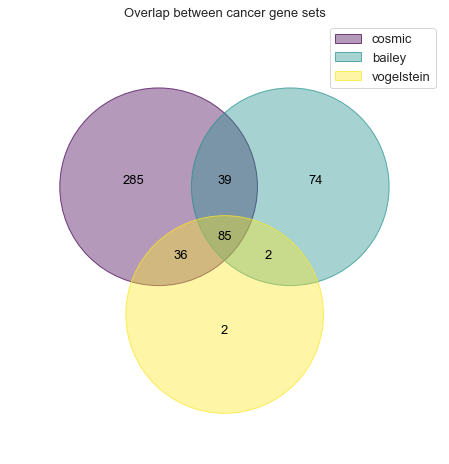

In [13]:
from venn import venn
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

label_map = {
    'cosmic': cosmic_genes,
    'bailey': bailey_genes,
    'vogelstein': vogelstein_genes
}
venn(label_map)
plt.title('Overlap between cancer gene sets', size=13)

### How many COSMIC genes have at least one valid cancer type?

Or, in other words, how many genes will we need to run our classifiers for?

In [17]:
import sys

from mpmp.data_models.tcga_data_model import TCGADataModel

def calculate_gene_count(genes_df, verbose):
    """For a set of data types, calculate the number of valid genes."""
    gene_list = []
    sample_info_df = du.load_sample_info('expression')
    tcga_data = TCGADataModel(seed=cfg.default_seed, verbose=verbose)
    for gene_ix, gene_series in genes_df.iterrows():
        try:
            if gene_ix % 10 == 0:
                print(gene_ix, '/', genes_df.shape[0], file=sys.stderr)
            tcga_data.process_data_for_gene(gene_series.gene,
                                            gene_series.classification,
                                            None)
        except KeyError:
            print('key error:', gene_series.gene)
            continue
        gene_list.append((gene_series.gene, tcga_data.X_df.shape[0]))
    return gene_list

In [18]:
genes_df = pd.read_csv(cfg.cosmic_with_annotations, sep='\t')
genes_df.head()

,gene,classification
0,ABI1,TSG
1,ABL1,Oncogene
2,ABL2,Oncogene
3,ACKR3,Oncogene
4,ACVR1,Oncogene


In [20]:
gene_list = calculate_gene_count(genes_df, verbose=False)
nonzero_genes = [g for g, c in gene_list if c > 0]
print('Nonzero genes:', len(nonzero_genes), '/', len(gene_list))

0 / 445


key error: AFDN


10 / 445
20 / 445
30 / 445
40 / 445
50 / 445
60 / 445
70 / 445
80 / 445
90 / 445


key error: CRLF2


100 / 445
110 / 445
120 / 445
130 / 445
140 / 445
150 / 445
160 / 445
170 / 445
180 / 445
190 / 445
200 / 445
210 / 445


key error: KNL1


220 / 445
230 / 445
240 / 445
250 / 445


key error: MRTFA


260 / 445
270 / 445
280 / 445


key error: NSD2
key error: NSD3


290 / 445


key error: P2RY8


300 / 445
310 / 445
320 / 445
330 / 445
340 / 445
350 / 445
360 / 445
370 / 445
380 / 445


key error: SSX2


390 / 445
400 / 445


key error: TENT5C


410 / 445
420 / 445
430 / 445
440 / 445


Nonzero genes: 236 / 436
